## 加载csv数据

In [200]:
import pandas as pd
import numpy as np

titanic_df = pd.read_csv('./titanic-data.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 是否存在缺失字段

In [201]:
titanic_df.isna().sum()/titanic_df.isna().count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

## 删除唔关字段
由于Name，Ticket与是否生还没有太大关系，故选择删除，另外仓位其实与是否生还有一定联系，但是从上面统计得知仓位缺失值超过半数，达到77.1%，缺失比例太高，已经没有太大分析意义，故也把该值删除。

In [202]:
# 删除Name，Ticket，Cabin，这些数据和生还率好像都没有什么关系，而且Cabin这个字段还记录不全
# Ticket这个字段对分析毫无作用
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Cabin']
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## 检查是否存在空值

In [203]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

经过统计，观察到Age存在空值，Embarked存在空值，先把Embarked空值的数据打印出来看看是什么数据

In [204]:
# 对登船记录做填充，因为登船记录只有两个数据缺失，所以直接补充为Unknown即可，这两个数据对分析关系不是很大
titanic_df.Embarked.fillna("Unknown", inplace=True)

In [205]:
# 因为年龄缺失值在20%左右，而且据当时历史了解，年龄层次不同与生还直接相关，所有有必要对年龄进行一些填补
# 统计以下填充前的年龄分布情况
titanic_df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [210]:
# 对年龄进行中位数填充，直接使用性别分组，统计各个性别年龄中位数进行填充，按照性别来分组，这样统计年龄相对来说比较合理
age_medians = titanic_df.groupby("Sex").Age.median()
print("age median:{}".format(age_medians))
titanic_df.set_index("Sex", inplace=True)
titanic_df.Age.fillna(age_medians, inplace=True)
titanic_df.reset_index("Sex", inplace=True)
titanic_df.Age.describe()

age median:Sex
female    27.0
male      29.0
Name: Age, dtype: float64


count    891.000000
mean      29.441268
std       13.018747
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

## 对填充后的年龄数据做直方图分析

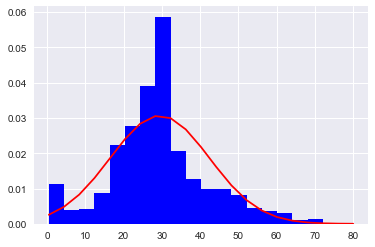

In [231]:
# 对填充后的年龄做一下分布情况统计
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

#据上面的统计，年龄最小的是几个月，最大的是80谁，所以对直方图，设计如下20个区间
num_bins=20
describe = titanic_df.Age.describe()
segma = describe['std']
mu = describe['mean']
# 拟合一条正态曲线
plt.close("all")
_, bins, _ = plt.hist(titanic_df.Age, normed=1, bins=num_bins, color="blue")
line = mlab.normpdf(bins, mu, segma)
plt.plot(bins, line, "red")
plt.show()

从直方图并结合当时的历史环境来看，填充还是比较符合预期
- 20-30岁的青壮、中年占比较多，这部分年龄阶层比较适合长途旅行、商务出行
- 符合当时社会年龄层次分布

## 统计从不同港口登船的人数占比

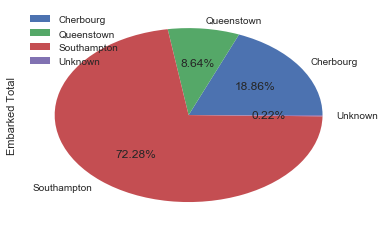

In [233]:
sns.set(color_codes=True)
plt.close('all')
embarked_total = titanic_df.groupby('Embarked').count()
# 生成饼图
labels = ['Cherbourg', 'Queenstown', 'Southampton', 'Unknown']
embarked_total.plot.pie(y='PassengerId', labels=labels, autopct='%1.2f%%')
plt.ylabel('Embarked Total')
plt.show()

<pre>从上图说得，很多旅客是从Southampton登船，其次是Cherbourg，再次是Queenstown，还有两位旅客未知
也因为Southampton是泰坦尼克号的启航地，所以登船人数最多
<pre>
[参考文献](https://zh.wikipedia.org/wiki/%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7)

## 问题1: 仓位等级是否和幸存相关？

In [356]:
survived_total = titanic_df.groupby(["Pclass", "Survived"], as_index=False).count()
pclass_count = titanic_df.groupby(["Pclass"], as_index=False).count()[["Pclass", "PassengerId"]]

print("统计各等级仓位的总人数：")
print(pclass_count)
print("---------------------------------")

# 把survived_total数据分成两组，一组只有幸存统计，一组只有死亡人数统计
not_surviveds = survived_total.loc[survived_total['Survived'] == 0][["Pclass", "PassengerId"]]
surviveds = survived_total.loc[survived_total['Survived'] == 1][["Pclass", "PassengerId"]]

not_surviveds['ratio'] = not_surviveds.PassengerId.div(not_surviveds.Pclass.map(pclass_count.set_index("Pclass").PassengerId))
surviveds['ratio'] = surviveds.PassengerId.div(surviveds.Pclass.map(pclass_count.set_index("Pclass").PassengerId))
print(not_surviveds)
print(surviveds)

统计各等级仓位的总人数：
   Pclass  PassengerId
0       1          216
1       2          184
2       3          491
---------------------------------
   Pclass  PassengerId     ratio
0       1           80  0.370370
2       2           97  0.527174
4       3          372  0.757637
   Pclass  PassengerId     ratio
1       1          136  0.629630
3       2           87  0.472826
5       3          119  0.242363


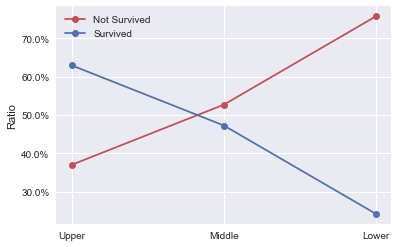

In [386]:
# 绘制比例图形对比结果
from matplotlib.ticker import FuncFormatter

plt.close("all")
def to_percent(y, position):
    return str(100 * y) + '%'
formatter = FuncFormatter(to_percent)
p1 = plt.plot(not_surviveds.Pclass, not_surviveds.ratio, "r-o")
p2 = plt.plot(surviveds.Pclass, surviveds.ratio, "b-o")
x_labels = ["Upper", "Middle", "Lower"]
plt.xticks(not_surviveds.Pclass, x_labels)
plt.ylabel("Ratio")
plt.legend((p1[0], p2[0]), ("Not Survived", "Survived"))
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

从上图可以看出：
- 生还率在阶级层面来看非常分明
- 越是头等舱的乘客越优先获救，头等舱的乘客接近63%被救出
- 3等仓虽然人数众多，但是也接近76%的人没有获救。

## 幸存和性别是否相关？

In [387]:
# 获取不同性别的幸存情况
sex_survived_total = titanic_df.groupby(["Sex", "Survived"], as_index=False).count()[['Sex', 'Survived', 'PassengerId']]
sex_total = titanic_df.groupby("Sex", as_index=False).count()[['Sex', 'PassengerId']]
sex_survived_total['ratio']=sex_survived_total.PassengerId.div(sex_survived_total.Sex.map(sex_total.set_index('Sex').PassengerId))
sex_survived_total

,Sex,Survived,PassengerId,ratio
0,female,0,81,0.257962
1,female,1,233,0.742038
2,male,0,468,0.811092
3,male,1,109,0.188908


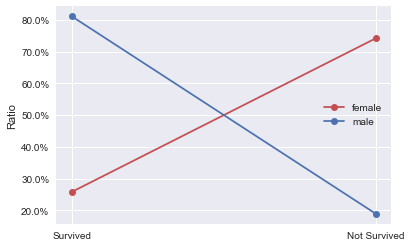

In [388]:
# 画图
female_ratio = sex_survived_total.loc[sex_survived_total['Sex']=='female']
male_ratio = sex_survived_total.loc[sex_survived_total['Sex']=='male']
# print(female_ratio)

p3 = plt.plot(female_ratio.Survived, female_ratio.ratio, "r-o")
p4 = plt.plot(male_ratio.Survived, male_ratio.ratio, "b-o")
x_labels = ["Survived", "Not Survived"]
plt.xticks(female_ratio.Survived, x_labels)
plt.ylabel("Ratio")
plt.legend((p3[0], p4[0]), ("female", "male"))
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()